<a href="https://colab.research.google.com/github/ovbystrova/dpl/blob/master/notebooks/Language_model_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install tokenizers

In [2]:
!git clone https://github.com/ovbystrova/dpl.git
import os
os.chdir('/content/dpl')

Cloning into 'dpl'...
remote: Enumerating objects: 185, done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 185
Receiving objects: 100% (185/185), 228.78 MiB | 27.99 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Checking out files: 100% (28/28), done.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
from modules.sntpiece_tokenization import make_tokenizer, clean_data, special_tokens

In [0]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 40

# Data 

In [0]:
%%capture
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

In [8]:
tokenizer = make_tokenizer()
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [0]:
%%capture
TEXT = data.Field(sequential=True, 
                  include_lengths=False, 
                  batch_first=True, 
                  tokenize=tokenize,
                  lower=True, 
                  pad_first=True)

train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

In [11]:
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 22734


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

In [12]:
train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=MAX_SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)

b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [0]:
# PAD
pad_idx = TEXT.vocab.stoi['<pad>']
pad_vec = TEXT.vocab.vectors[1]

# Model

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        self.fc2 = nn.Linear(vocab_size, embed_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, 'text') else batch
        
        x = self.embedding(x)           
        x, _ = self.rnn(x)  # (bs,sq,hs)
        x = self.fc(x)  # (bs,sq,vocab_size)
        x = F.softmax(x, dim=-1)  # (bs,sq,vocab_size)
        x = self.fc2(x)  # (bs,sq,embed_size)
        return x

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )
model.to(device)
model.embedding.weight.data.copy_(TEXT.vocab.vectors);

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

criterion = nn.CrossEntropyLoss(ignore_index=1)
cosine = nn.CosineSimilarity(dim=-1)
mse = nn.MSELoss()
embed_y = nn.Embedding(len(TEXT.vocab.itos), 200).to(device)  
embed_y.weight.data.copy_(TEXT.vocab.vectors);

In [16]:
embed_y.weight.data, model.embedding.weight.data

(tensor([[ 3.0568,  0.5324,  0.5345,  ...,  0.9580, -2.3471, -0.8556],
         [ 0.7384,  2.5978,  0.7651,  ..., -1.1332, -0.6784,  0.7710],
         [-1.2101,  0.7566, -0.1192,  ..., -0.0474,  0.1571, -0.9504],
         ...,
         [ 0.9455,  1.1042, -1.0881,  ..., -0.7559, -1.0561, -1.2703],
         [ 0.3659,  0.6635,  0.2631,  ...,  0.1843,  0.2070, -0.4724],
         [-0.3153, -0.4700,  0.1212,  ...,  1.4813,  0.4461,  0.7010]],
        device='cuda:0'),
 tensor([[ 3.0568,  0.5324,  0.5345,  ...,  0.9580, -2.3471, -0.8556],
         [ 0.7384,  2.5978,  0.7651,  ..., -1.1332, -0.6784,  0.7710],
         [-1.2101,  0.7566, -0.1192,  ..., -0.0474,  0.1571, -0.9504],
         ...,
         [ 0.9455,  1.1042, -1.0881,  ..., -0.7559, -1.0561, -1.2703],
         [ 0.3659,  0.6635,  0.2631,  ...,  0.1843,  0.2070, -0.4724],
         [-0.3153, -0.4700,  0.1212,  ...,  1.4813,  0.4461,  0.7010]],
        device='cuda:0'))

# Training

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0
    losses = []
    cosines = []

    n_batches = len(iterator)
    # iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        y_emb = embed_y(batch.target.T)

        loss = mse(pred, y_emb)
        losses.append(loss.item())
        loss.backward()

        cosine_batch = (1- torch.mean(torch.mean(cosine(pred, y_emb)), dim=-1)).item()
        cosines.append(cosine_batch)
        
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        # iterator.set_postfix(loss='%.5f' % running_loss, cosine='%.5f' % cosine_batch)

    return running_loss, losses, cosines

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    losses = []
    cosines = []

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            y_emb = embed_y(batch.target.T)
            loss = mse(pred, y_emb)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

            cosine_batch = (1- torch.mean(torch.mean(cosine(pred, y_emb)), dim=-1)).item()
            cosines.append(cosine_batch)

    return epoch_loss / n_batches, losses, cosines

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    model = model.to(device)
    criterion = criterion.to(device)
    
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []
    train_cosines = []
    valid_cosines = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl, epoch_tcosines = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl, epoch_vcosines = _test_epoch(model, valid_iterator, criterion)
        
        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)
        train_cosines.extend(epoch_tcosines)
        valid_cosines.extend(epoch_vcosines)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, train_losses, valid_losses, train_cosines, valid_cosines

In [20]:
for el in train_iterator:
    x = el.text
    y = el.target.T
    print(x.size(), y.size())
    pred = model(el)
    y_emb = embed_y(y)
    loss_mse = mse(pred, y_emb)
    print('mse', loss_mse)
    loss_cosine = cosine(pred, y_emb)
    print('cosine', loss_cosine.size())

    mean_cosine  = torch.mean(loss_cosine, dim=-1)
    mean_mean_cosine = torch.mean(mean_cosine)
    print(mean_cosine.size(), mean_mean_cosine.size())
    print(1-mean_mean_cosine)
    break

torch.Size([40, 64]) torch.Size([64, 40])
mse tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
cosine torch.Size([64, 40])
torch.Size([64]) torch.Size([])
tensor(0.9936, device='cuda:0', grad_fn=<RsubBackward1>)


In [21]:
history, train_losses, valid_losses, train_cosines, valid_cosines = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=50, early_stopping=2)

validation loss 0.66484
validation loss 0.61326
validation loss 0.60708
validation loss 0.59953
validation loss 0.57326
validation loss 0.55054
validation loss 0.54621
validation loss 0.53878
validation loss 0.52611
validation loss 0.51726
validation loss 0.51272
validation loss 0.50932
validation loss 0.50829
validation loss 0.50752
validation loss 0.50706
validation loss 0.50677
validation loss 0.50652
validation loss 0.50638
validation loss 0.50649
validation loss 0.50495
validation loss 0.50275
validation loss 0.50243
validation loss 0.49832
validation loss 0.49631
validation loss 0.49535
validation loss 0.49410
validation loss 0.49295
validation loss 0.49219
validation loss 0.48974
validation loss 0.48289
validation loss 0.47777
validation loss 0.47653
validation loss 0.47596
validation loss 0.47555
validation loss 0.47545
validation loss 0.47524
validation loss 0.47511
validation loss 0.47507
validation loss 0.47514
validation loss 0.47544
Early stopping! best epoch: 37 val 0.475

In [0]:
torch.save(model.state_dict(), '/content/language_model')

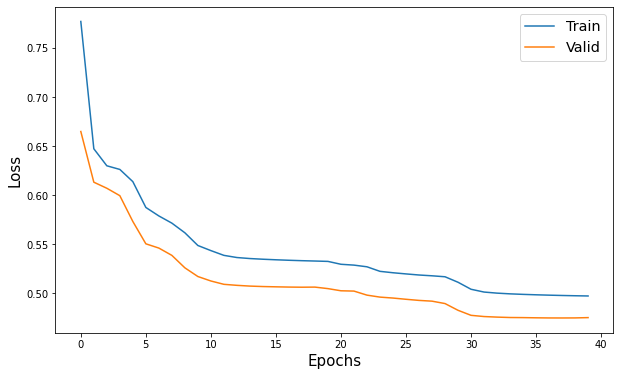

In [23]:
# Loss by epoch
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

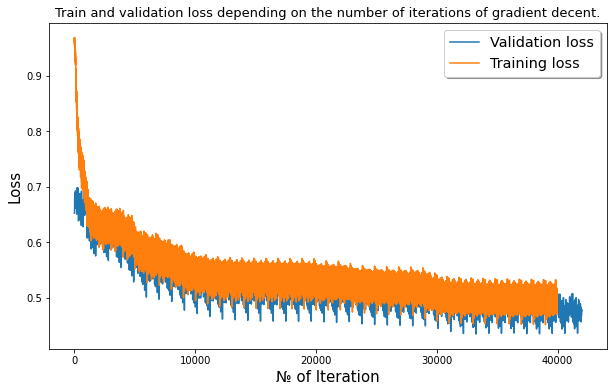

In [24]:
# Loss by iteration
new_val = [el for el in valid_losses for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(new_val, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation loss depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

In [25]:
embed_y.weight.data, model.embedding.weight.data

(tensor([[ 3.0568,  0.5324,  0.5345,  ...,  0.9580, -2.3471, -0.8556],
         [ 0.7384,  2.5978,  0.7651,  ..., -1.1332, -0.6784,  0.7710],
         [-1.2101,  0.7566, -0.1192,  ..., -0.0474,  0.1571, -0.9504],
         ...,
         [ 0.9455,  1.1042, -1.0881,  ..., -0.7559, -1.0561, -1.2703],
         [ 0.3659,  0.6635,  0.2631,  ...,  0.1843,  0.2070, -0.4724],
         [-0.3153, -0.4700,  0.1212,  ...,  1.4813,  0.4461,  0.7010]],
        device='cuda:0'),
 tensor([[ 2.2789,  0.3433,  0.3739,  ...,  0.7692, -1.9724, -0.6518],
         [ 0.2965,  2.6320,  0.5940,  ..., -0.7412, -0.4479,  0.7221],
         [-0.9162,  0.5814, -0.0398,  ...,  0.0409,  0.0341, -0.5065],
         ...,
         [ 0.9684,  1.2801, -1.0479,  ..., -0.7708, -1.1880, -1.2993],
         [ 0.4129,  0.6676,  0.2293,  ...,  0.0840,  0.1725, -0.4951],
         [-0.3734, -0.3613,  0.0863,  ...,  1.4798,  0.6182,  0.8118]],
        device='cuda:0'))

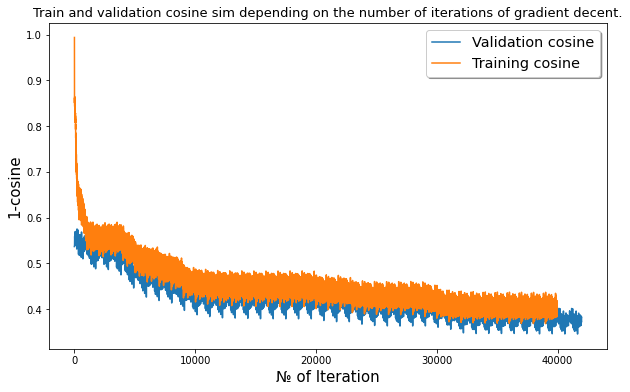

In [26]:
# 1-Cosine by iteration
new_cos = [el for el in valid_cosines for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(new_cos, label='Validation cosine')
plt.plot(train_cosines, label='Training cosine')
plt.ylabel('1-cosine', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation cosine sim depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

In [53]:
test_loss, epoch_test, epoch_tcosines = _test_epoch(model, test_iterator, mse)
test_loss

0.46747628798087437

# just some stuff

In [48]:
texts = [
         '<start>',
         'Test test test test test test test',
         '<eos>',
         'What is love',
         '▁', 
         'A ▁very ▁very ▁long ▁text',
         "And even longer text with ▁ symbol in the end ▁",
         'Who is',
         'It was a very sunny',
         'love is a', 
         'love is',
         'Homarus gammarus, known as the European', #lobster
         'russia is'
         ''
]

def predict(model, text, vocab, cosine=cosine, tokenize=tokenize):
    '''
    Finds the most similar token from vocab based on cosine sim

    text: input text (str)
    vocab: nn.Embedding layer of embed_y (vocab_size, embed_dim)

    '''

    tokenized = tokenize(text)
    ids = [TEXT.vocab.stoi[token] for token in tokenized]
    x = torch.tensor(ids).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x)
        cosines = cosine(pred[:,-1,:], vocab.weight.data)
        cosine_sim = torch.max(cosines).item()
        next_token_id = torch.argmax(cosines)
        next_token = TEXT.vocab.itos[next_token_id]
        # print(next_token)
        print(text + ' PREDICTION: ' + next_token + ' SCORE: ' + str(cosine_sim))
        print()
        next_token += ' '
    return text + ' ' + next_token[1:]
for text in texts:
    predict(model, text, embed_y)

<start> PREDICTION: ▁ SCORE: 0.9999924898147583

Test test test test test test test PREDICTION: ▁, SCORE: 0.8348450064659119

<eos> PREDICTION: <start> SCORE: 0.9999954700469971

What is love PREDICTION: ▁" SCORE: 0.9310120940208435

▁ PREDICTION: <eos> SCORE: 0.9999990463256836

A ▁very ▁very ▁long ▁text PREDICTION: ▁on SCORE: 0.5553016066551208

And even longer text with ▁ symbol in the end ▁ PREDICTION: <unk> SCORE: 0.8982264995574951

Who is PREDICTION: ▁a SCORE: 0.8570911288261414

It was a very sunny PREDICTION: ▁and SCORE: 0.6508579850196838

love is a PREDICTION: ▁ SCORE: 0.6303699016571045

love is PREDICTION: ▁a SCORE: 0.8783660531044006

Homarus gammarus, known as the European PREDICTION: ▁, SCORE: 0.4945244789123535

russia is PREDICTION: ▁a SCORE: 0.8731896281242371

